In [ ]:
import geopandas as gpd
import folium
from shapely.geometry import box
from shapely.ops import unary_union
import json

In [ ]:
gdf = gpd.read_file("./resources/FAO_fishing_areas/FAO_AREAS_ERASE_LOWRES.json")

<Axes: >

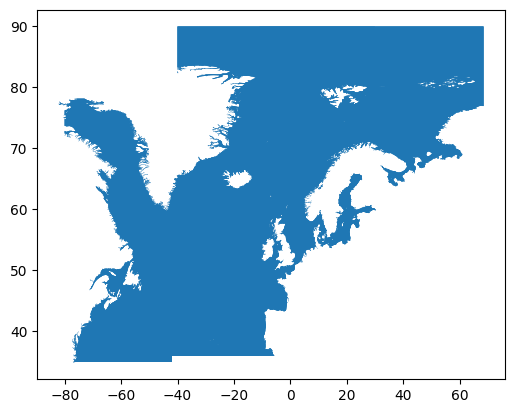

In [19]:
fao_27_21= gdf[gdf["F_AREA"].isin(["27", "21"])]
fao_27_21.plot()

In [20]:
#Now only up to 60ºN for the satellite accuracy. 

# World extent above 60ºN
above_60N = gpd.GeoDataFrame(
    geometry=[box(-180, 60, 180, 90)],
    crs="EPSG:4326"
)

# Perform spatial difference
fao_27_21_below_60N = fao_27_21.overlay(above_60N, how="difference")
fao_27_21_below_60N = fao_27_21_below_60N.to_crs(epsg=3857)


In [ ]:
selected = fao_27_21_below_60N.to_crs(epsg=4326)
# Center map on the centroid of the selected areas
center = selected.geometry.union_all().centroid
m = folium.Map(location=[center.y, center.x], zoom_start=3)

folium.GeoJson(
    selected,
    name="Selected FAO Areas",
    tooltip=folium.GeoJsonTooltip(fields=["NAME_EN", "F_AREA"]),
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.5,
    },
).add_to(m)

m.save("./maps/fao_27_21_below_60N.html")

<Axes: >

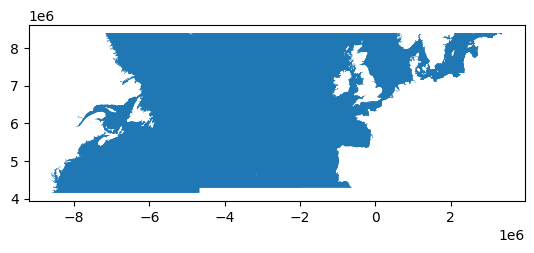

In [22]:
fao_27_21_below_60N.plot()

In [ ]:
# Step 1: Merge all geometries
merged_geometry = unary_union(fao_27_21_below_60N.geometry)
# Merge all geometries into one unified Polygon

# If it's still a MultiPolygon, simplify to the largest part
if merged_geometry.geom_type == 'MultiPolygon':
    merged_geometry = max(merged_geometry.geoms, key=lambda p: p.area)
    print("is multi")
# Step 2: Wrap in GeoDataFrame and assign CRS
gdf_merged = gpd.GeoDataFrame(geometry=[merged_geometry], crs=fao_27_21_below_60N.crs)

# Step 3: Reproject to geographic coordinates (EPSG:4326)
gdf_merged = gdf_merged.to_crs(epsg=4326)

# Step 4: Convert to GeoJSON-like dictionary
geojson_geometry = json.loads(gdf_merged.to_json())['features'][0]['geometry']

geojson_payload = {
    "geojson": {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {},
                "geometry": geojson_geometry
            }
        ]
    }
}

# Step 5: Save to GeoJSON file
with open("./data/GFW_polygon.geojson", "w") as f:
    json.dump(geojson_payload, f, indent=2)

is multi


<Axes: >

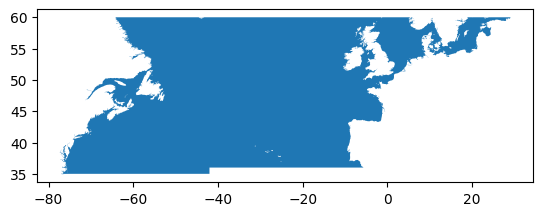

In [ ]:
# Load the GeoJSON
gdf = gpd.read_file("./data/GFW_polygon.geojson")

# Step 1: Assign the correct CRS if missing (likely EPSG:3857 for meters)
if gdf.crs is None:
    gdf.set_crs(epsg=3857, inplace=True)

# Step 2: Reproject to WGS84 (longitude/latitude)
gdf = gdf.to_crs(epsg=4326)

# Step 3: Plot
gdf.plot()